# Combining snowfall detection procedure and snow compaction/temperature models

This notebook uses and combines the preliminary work done previously to see if models and procedures developed so far are consistent with observations.

We detect snow accumulation and erosion events, build layers accordingly, simulate their evolution and plot our results against the snow-depth curve obtained from the lidar.

### Imports and functions

In [2]:
%run little_awk_functions.py


### Define data

In [3]:
# Get data from files

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')

# all_data = xr.open_mfdataset('/home/mabonnet/Desktop/data/2021_2022_livox_surfaces/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# all_data.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_2021-2022.nc')
all_data_set = xr.open_dataset('data_2021-2022.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(84,106), y=slice(28,50)).to_netcdf('snow_pit_1.nc')
data_pit_1 = xr.open_dataset('snow_pit_1.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(105,127), y=slice(39,61)).to_netcdf('snow_pit_2.nc')
data_pit_2 = xr.open_dataset('snow_pit_2.nc')

# data_dec_jan_fev_filled = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev_filled.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_filled_pit.nc')
data_dec_jan_feb_filled = xr.open_dataset('data_dec_jan_feb_filled_pit.nc')

In [4]:
# Define which dataset to use in what follows

data_set_used = data_dec_jan_feb
# data_set_used

In [5]:
# Pre-processing to get clean data

if data_set_used == all_data_set:
    fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
if data_set_used == all_data_set:
    median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() #- data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time= start_accumulation[0])


---> Median filtering in space with a window [7, 11]


### Define parameters

In [6]:
# Defining parameters for snow events detection

x_sel = 20
y_sel = 20
time_window_std = 25
std_threshold = 0.015

data_starting_date_in_ns = float(data_set_used.time.values[0])
# print(data_starting_date_in_ns)
# 1638796500000000000 is the first time point in data_dec_jan_feb
# 1625149800000000000 is the first time point in all_data_set (2021-07-01-16:30)
# 1638316800000000000 is the first time point in the snowpit datasets
# 1630454400000000000 is the first time point in Crocus

In [7]:
# Initial state for compaction/temperature model, with 0 layers

# Adaptable parameters
tsfc = -15
cp_snow = 2.1
dt = 100
a1 = 0.0013
a2 = 0.021

max_nb_of_layers = 20

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
# print(data_duration_in_s)
nb_iterations = int(data_duration_in_s/dt + 1)
# print(nb_iterations)

# 'Fixed' parameters
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0
ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))


### Get snow events timing

In [8]:

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]


In [9]:
# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


### Simulate evolution of snowpack

In [10]:
# Update variables at each timepoint

ro_layer_evolution, depth_evolution, temperature_evolution = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                                                                        start_accumulation, end_accumulation, start_erosion, end_erosion,
                                                                                        jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2)

# ro_layer_evolution_artif, depth_evolution_artif, temperature_evolution_artif = simulate_snowpack_evolution_artif(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
 #                                                                                       start_accumulation, end_accumulation, start_erosion, end_erosion,
  #                                                                                      jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2)


### Plot evolution of snowpack, compare with lidar measurements

()

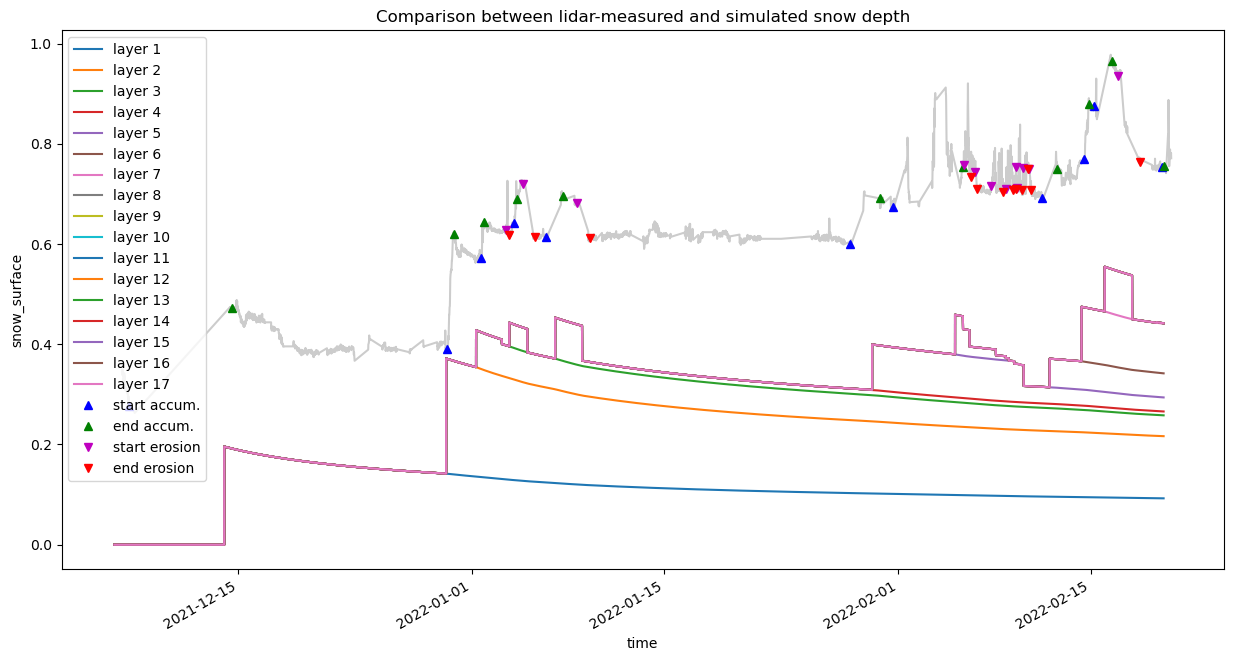

In [11]:
data_start_date = pd.to_datetime('2021-12-06T00:00')

plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, 17, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion,
                     save_file=False, my_file_name='index_window_point_20-20_-1.png')

In [24]:
# Note on the above figure: if erosion and accumulation are quasi-simultaneous, they will not be taken into account (the timestamp is passed, so we add a layer, 
# and then delete it because the other timestamp is passed). If the erosion is smalle rthan the accumulation, the same thing happens but instead of deleting the layer we just added,
# we reduce it and thus create a small layer.

# The code does what we want it to correctly, even though looking at the curves may be confusing because we cannot see the discretization directly.


#### Other plots, less interesting for now

Text(0, 0.5, 'Density')

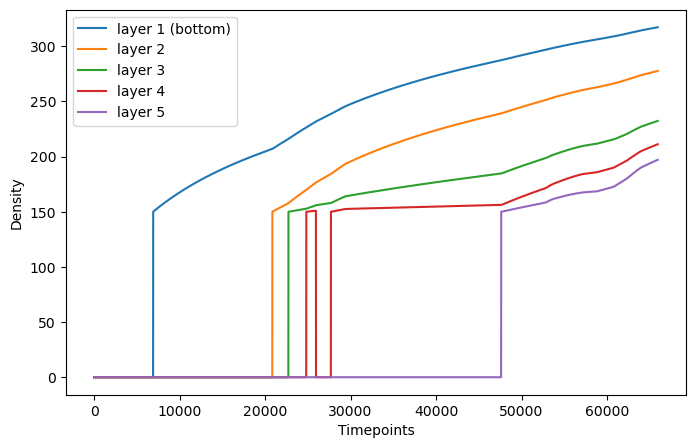

In [22]:
# Density

layer1 = [ro_layer_evolution[i][0] for i in range(len(ro_layer_evolution))]
layer2 = [ro_layer_evolution[i][1] for i in range(len(ro_layer_evolution))]
layer3 = [ro_layer_evolution[i][2] for i in range(len(ro_layer_evolution))]
layer4 = [ro_layer_evolution[i][3] for i in range(len(ro_layer_evolution))]
layer5 = [ro_layer_evolution[i][4] for i in range(len(ro_layer_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Density')

NameError: name 'layer6' is not defined

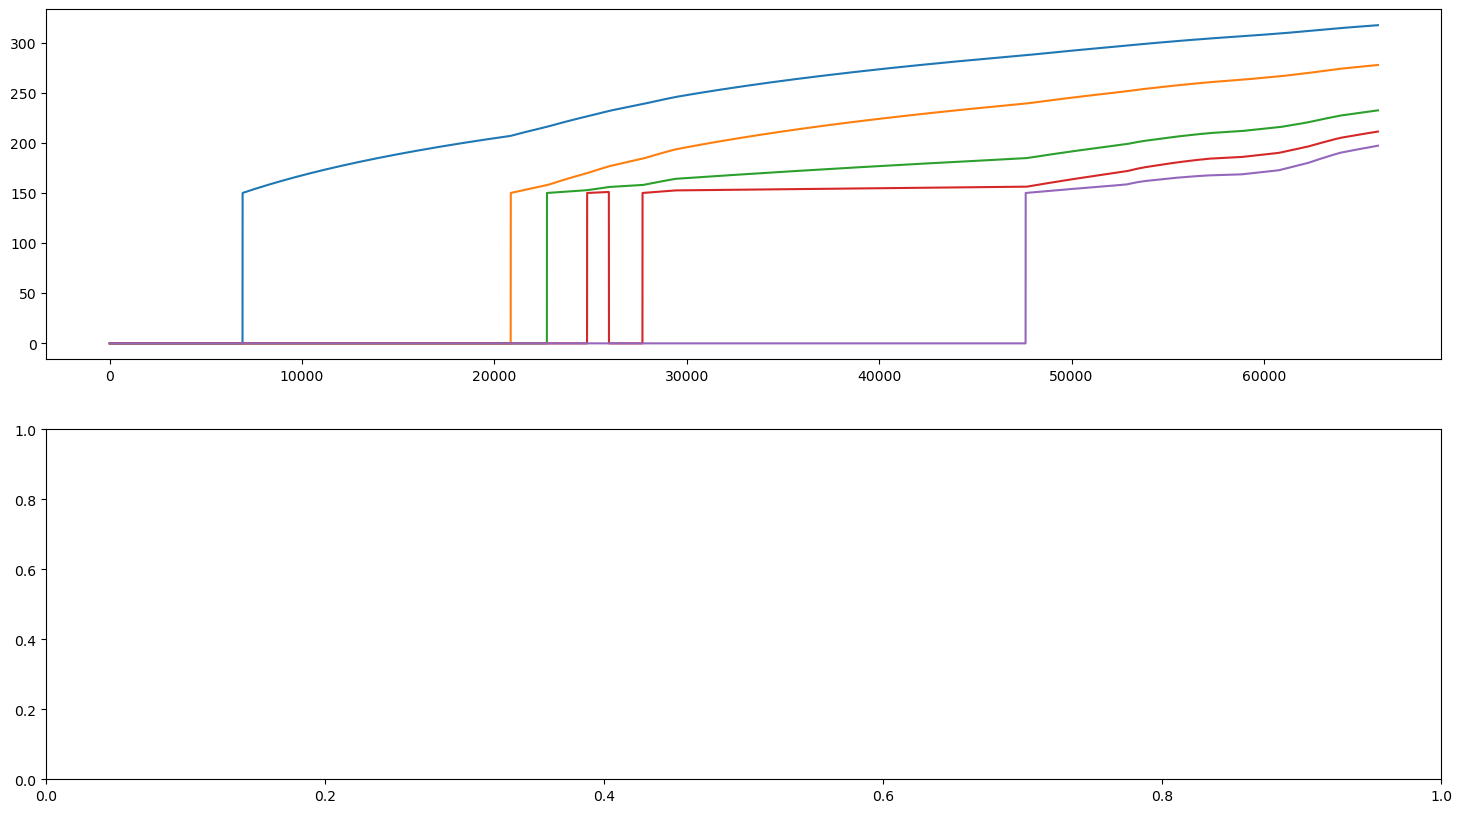

In [23]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(18, 10))

ax[0].plot(layer1, label='layer 1')
ax[0].plot(layer2, label='layer 2')
ax[0].plot(layer3, label='layer 3')
ax[0].plot(layer4, label='layer 4')
ax[0].plot(layer5, label='layer 5')
ax[0].plot(layer6, label='layer 6')
ax[0].plot(layer7, label='layer 7')
ax[0].plot(layer8, label='layer 8')
ax[0].plot(layer9, label='layer 9')
ax[0].plot(layer10, label='layer 10')
ax[0].plot(layer11, label='layer 11')
ax[0].plot(layer12, label='layer 12')

ax[0].set_ylabel('simulated snow depth')

data_set_used.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2, ax=ax[1])

data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion', ax=ax[1])
ax[1].legend()

ax[0].set_title('Comparison between lidar-measured and simulated snow depth')

# fig.savefig('measured_vs_simul_snow_depth.png')

In [ ]:
# Temperature

layer1 = [temperature_evolution[i][0] for i in range(len(temperature_evolution))]
layer2 = [temperature_evolution[i][1] for i in range(len(temperature_evolution))]
layer3 = [temperature_evolution[i][2] for i in range(len(temperature_evolution))]
layer4 = [temperature_evolution[i][3] for i in range(len(temperature_evolution))]
layer5 = [temperature_evolution[i][4] for i in range(len(temperature_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Temperature')

In [ ]:
# TODO pas de temps sont trop grands pour temperature ?